In [1]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import segmentation_models as sm

from train import dataset, aug

2023-01-26 11:31:48.251386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 11:31:48.496282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/flex/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/galactic/opt/yaml_cpp_vendor/lib:/opt/ros/galactic/opt/rviz_ogre_vendor/lib:/opt/ros/galactic/lib/x86_64-linux-gnu:/opt/ros/galactic/lib
2023-01-26 11:31:48.496332: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GP

Segmentation Models: using `keras` framework.


In [2]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 8
CLASSES = ['car', 'pedestrian']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [3]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

2023-01-26 11:31:57.602372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 11:31:57.603134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/flex/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/galactic/opt/yaml_cpp_vendor/lib:/opt/ros/galactic/opt/rviz_ogre_vendor/lib:/opt/ros/galactic/lib/x86_64-linux-gnu:/opt/ros/galactic/lib
2023-01-26 11:31:57.603291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PAT

In [4]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1, 2, 0.5])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [5]:
model.load_weights('best_model.h5') 

In [6]:
test_dataset = dataset.Dataset(
    'CamVid/test/', 
    'CamVid/testannot/', 
    classes=CLASSES, 
    augmentation=aug.get_validation_augmentation(),
    preprocessing=aug.get_preprocessing(preprocess_input),
)

test_dataloader = dataset.Dataloder(test_dataset, batch_size=1, shuffle=False)

In [7]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

233/233 [==============================] - 102s 414ms/step - loss: 0.2567 - iou_score: 0.6928 - f1-score: 0.7674
Loss: 0.25671
mean iou_score: 0.69278
mean f1-score: 0.7674


1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


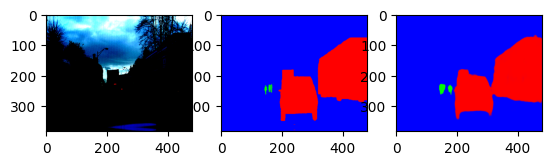

In [8]:
image, gt_mask = test_dataset[42]
image = np.expand_dims(image, axis=0)
pr_mask = model.predict(image)

plt.subplot(131)
plt.imshow(image[0,:,:,:])
plt.subplot(132)
plt.imshow(gt_mask)
plt.subplot(133)
plt.imshow(pr_mask[0,:,:,:])
plt.show()